It is crucial that you thoroughly read the tutorial before starting this challenge. For the first part we will closely follow <a href="https://arxiv.org/abs/2002.11217">M. Khezri et al. Anneal-path correction in flux qubits</a> Suplementary material section 3.

In [141]:
# import all necessary libraries (feel free to add more if you need them)
import cas

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh

In [156]:
SIG_X = np.array([[0, 1], [1, 0]])
SIG_Y = np.array([[0, - 1j], [1j, 0]])
SIG_Z = np.array([[1, 0], [0, -1]])
SIG_I = np.array([[1, 0], [0, 1]])

In [209]:
def sort_trash_from_eigsh(eig_vals, eig_vects):
    dict_val_vect = dict()
    for i, val in enumerate(eig_vals):
        dict_val_vect[val] = eig_vects[:, i]
    sorted_dict = dict(sorted(dict_val_vect.items()))
    return sorted_dict

## Part 1 - Exploring the qubit space

#### Qubit definition
The first step is to create a qubit object. We will be using the CAS code for that. We will take the parameters given by <a href="https://arxiv.org/abs/2103.06461">M. Khezri et al. Customized quantum annealing schedules</a>

In [2]:
i_c = 242; c_shunt = 62; c_z = 4.85; lq = 480; alpha = 0.4; d = 0
# create a qubit
qubit = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)

/home/derik/.local/miniconda3/envs/haqtoberfest/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


#### Exercise 1:
You can get the hamiltonian with `qubit.get_h(phi_x, phi_z)`. Do a sweep on a reasonable range of $\Phi_x$, $\Phi_z$ and plot the energy gap of the ground and excited levels of the qubits for that range. You should obtain a figure like the following:

We start with a broad range in $\Phi_x$ and $\Phi_z$ to study the properties of the system.

In [29]:
phis_x = np.linspace(-2 * np.pi, 2 * np.pi, 100)
phis_z = np.linspace(-2 * np.pi, 2 * np.pi, 100)

dEs = np.empty((len(phis_x), len(phis_z)))
for i, phi_x in enumerate(phis_x):
    for j, phi_z in enumerate(phis_z):
        H = qubit.get_h(phi_x, phi_z)a
        energies = eigsh(H, k=2, which="SA", return_eigenvectors=False)
        dE = (energies[0] - energies[1]) / (200 * np.pi)
        dEs[i][j] = dE 

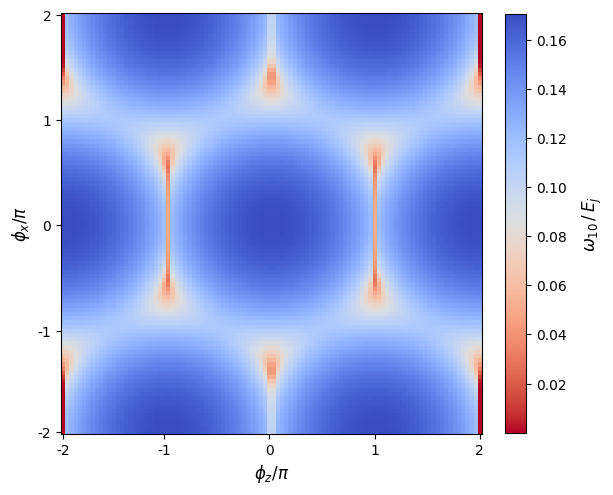

In [328]:
plt.figure(figsize=(6, 6))

plt.imshow(dEs, aspect="equal", origin="lower", cmap="coolwarm_r", interpolation='none')
plt.xlabel(r"$\phi_z / \pi$", fontsize=12)
plt.ylabel(r"$\phi_x / \pi$", fontsize=12)
plt.xticks([0, 24, 49, 74, 99], [-2, -1, 0, 1, 2])
plt.yticks([0, 24, 49, 74, 99], [-2, -1, 0, 1, 2])
cb = plt.colorbar(fraction=0.045)
cb.set_label(r"$\omega_{10} \, / \, E_j$", size=12, labelpad=10)

plt.show()

In the figure above, we see a periodicity in both variables, so we focus the study on this propierty.

In [250]:
phis_x = np.linspace(1.3 * np.pi, 2.7 * np.pi, 140)
phis_z = np.linspace(-0.4 * np.pi, 0.4 * np.pi, 80)

dEs_red = np.empty((len(phis_x), len(phis_z)))
for i, phi_x in enumerate(phis_x):
    for j, phi_z in enumerate(phis_z):
        H = qubit.get_h(phi_x, phi_z)
        dict_energy_state = sort_trash_from_eigsh(*eigsh(H, k=2, which="SA", return_eigenvectors=True))
        energies = list(dict_energy_state.keys())
        dE = (energies[1] - energies[0]) / (200 * np.pi)
        dEs_red[i][j] = dE
        clear_output(wait=True)
        print(str(i + 1) + "/" + str(len(phis_x)) + ", " + str(j + 1) + "/" + str(len(phis_z)))

140/140, 80/80


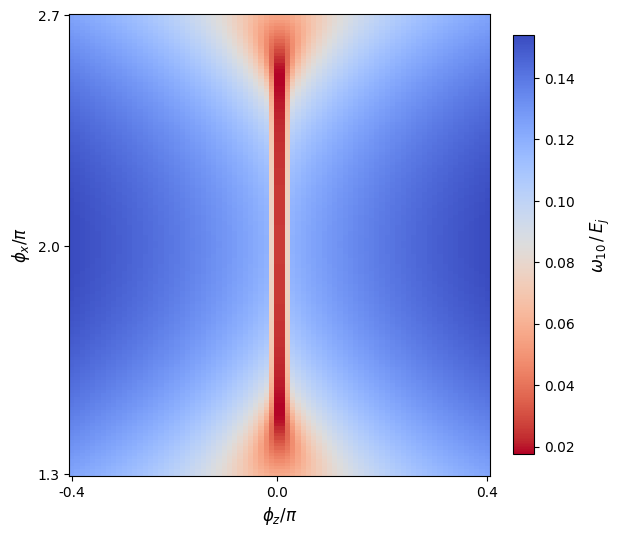

In [329]:
plt.figure(figsize=(6, 6))

plt.imshow(dEs_red, aspect="auto", origin="lower", cmap="coolwarm_r", interpolation='none')
plt.xlabel(r"$\phi_z / \pi$", fontsize=12)
plt.ylabel(r"$\phi_x / \pi$", fontsize=12)
plt.xticks([0, 39, 79], [-0.4, 0.0, 0.4])
plt.yticks([0, 69, 139], [1.3, 2.0, 2.7])
cb = plt.colorbar(fraction=0.045)
cb.set_label(r"$\omega_{10} \, / \, E_j$", size=12, labelpad=10)

plt.show()

#### Exercise 2:
The persistent current operator is defined as $$\hat{I_p} = \frac{\partial H(\Phi_x, \Phi_z)}{\partial \Phi_z}$$
Calculate $I_p^{low}$ as defined in Khezri's paper (suplementary note 3). Then plot the first and second eigvenvalues of the persistent current to identify the valid anneal regions.

In [252]:
phis_x = np.linspace(1.3 * np.pi, 2.7 * np.pi, 140) #140
phis_z = np.linspace(-0.4 * np.pi, 0.4 * np.pi, 80) #80

dphi_z = 0.5 * (phis_z[-1] - phis_z[0]) / len(phis_z)

Is_current_g = np.empty((len(phis_x), len(phis_z)))
Is_current_e = np.empty((len(phis_x), len(phis_z)))
Is_bases = dict()
for i, phi_x in enumerate(phis_x):
    for j, phi_z in enumerate(phis_z):
        H = qubit.get_h(phi_x, phi_z)
        dict_energy_state = sort_trash_from_eigsh(*eigsh(H, k=2, which="SA", return_eigenvectors=True))
        energies = list(dict_energy_state.keys())
        ##########################################################################
        H_p = qubit.get_h(phi_x, phi_z + dphi_z)
        H_m = qubit.get_h(phi_x, phi_z - dphi_z)
        dH = 0.5 * (H_p - H_m) / dphi_z
        Ip_g = dH @ dict_energy_state[energies[0]]
        Ip_e = dH @ dict_energy_state[energies[1]]
        Ip = np.array([
             [np.vdot(dict_energy_state[energies[0]], Ip_g), np.vdot(dict_energy_state[energies[0]], Ip_e)],
             [np.vdot(dict_energy_state[energies[1]], Ip_g), np.vdot(dict_energy_state[energies[1]], Ip_e)]
             ])
        ##########################################################################
        dict_current_state = sort_trash_from_eigsh(*eigsh(Ip, k=2, which="SA", return_eigenvectors=True))
        currents = list(dict_current_state.keys())
        Is_current_g[i][j] = currents[0]
        Is_current_e[i][j] = currents[1]
        Is_bases[str(i) + "," + str(j)] = np.column_stack((dict_current_state[currents[0]], dict_current_state[currents[1]]))
        clear_output(wait=True)
        print(str(i + 1) + "/" + str(len(phis_x)) + ", " + str(j + 1) + "/" + str(len(phis_z)))

140/140, 80/80


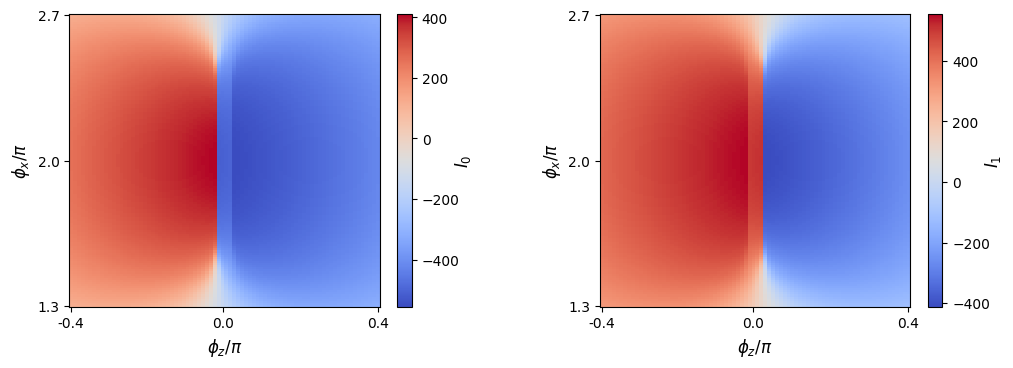

In [256]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
fig.tight_layout(pad=10)

pcm0 = axs[0].imshow(Is_current_g, aspect="auto", origin="lower", cmap="coolwarm", interpolation='none')
axs[0].set_xlabel(r"$\phi_z / \pi$", fontsize=12)
axs[0].set_ylabel(r"$\phi_x / \pi$", fontsize=12)
axs[0].set_xticks([0, 39, 79], [-0.4, 0.0, 0.4])
axs[0].set_yticks([0, 69, 139], [1.3, 2.0, 2.7])
cb = fig.colorbar(pcm0, fraction=0.06)
cb.set_label(r"$I_0$", size=12, labelpad=-5)

pcm1 = axs[1].imshow(Is_current_e, aspect="auto", origin="lower", cmap="coolwarm", interpolation='none')
axs[1].set_xlabel(r"$\phi_z / \pi$", fontsize=12)
axs[1].set_ylabel(r"$\phi_x / \pi$", fontsize=12)
axs[1].set_xticks([0, 39, 79], [-0.4, 0.0, 0.4])
axs[1].set_yticks([0, 69, 139], [1.3, 2.0, 2.7])
cb = fig.colorbar(pcm1, fraction=0.06)
cb.set_label(r"$I_1$", size=12, labelpad=-5)

plt.show()

We see that, near $\Phi_z \approx 0$, the eigenvalues of the persistent-current operator $I_p^{low}$ have opposite sign. Since this is a characteristic of a flux qubit, we restric the study to this zone.

#### Exercise 3:
Still following the same section from Khezri's paper, now calculate the values for the ising coefficients of the effective hamiltonian. Pay special attention to the contraints applied so that $H_{eff}$ can be expressed solely in terms of $\sigma_x$ and $\sigma_z$.

The constraints can be easily applied through a rotation in the $\vec{\sigma}$ space, where $\hat{H}_{eff}$ is defined: Rotating along $\sigma_z$ can eliminate the contribution of $\sigma_y$, remaining only the standard transverse field Ising Hamiltonian.

In [257]:
phis_x = np.linspace(1.0 * np.pi, 2.0 * np.pi, 140) #140
phis_z = np.linspace(-0.08 * np.pi, 0.08 * np.pi, 80) #80

dphi_z = 0.5 * (phis_z[-1] - phis_z[0]) / len(phis_z)

Hs_energy_g = np.empty((len(phis_x), len(phis_z)))
Hs_energy_e = np.empty((len(phis_x), len(phis_z)))
Is_current_g = np.empty((len(phis_x), len(phis_z)))
Is_current_e = np.empty((len(phis_x), len(phis_z)))
Is_bases = dict()
for i, phi_x in enumerate(phis_x):
    for j, phi_z in enumerate(phis_z):
        H = qubit.get_h(phi_x, phi_z)
        dict_energy_state = sort_trash_from_eigsh(*eigsh(H, k=2, which="SA", return_eigenvectors=True))
        energies = list(dict_energy_state.keys())
        Hs_energy_g[i][j] = energies[0]
        Hs_energy_e[i][j] = energies[1]
        ##########################################################################
        H_p = qubit.get_h(phi_x, phi_z + dphi_z)
        H_m = qubit.get_h(phi_x, phi_z - dphi_z)
        dH = 0.5 * (H_p - H_m) / dphi_z
        Ip_g = dH @ dict_energy_state[energies[0]]
        Ip_e = dH @ dict_energy_state[energies[1]]
        Ip = np.array([
             [np.vdot(dict_energy_state[energies[0]], Ip_g), np.vdot(dict_energy_state[energies[0]], Ip_e)],
             [np.vdot(dict_energy_state[energies[1]], Ip_g), np.vdot(dict_energy_state[energies[1]], Ip_e)]
             ])
        ##########################################################################
        dict_current_state = sort_trash_from_eigsh(*eigsh(Ip, k=2, which="SA", return_eigenvectors=True))
        currents = list(dict_current_state.keys())
        Is_current_g[i][j] = currents[0]
        Is_current_e[i][j] = currents[1]
        Is_bases[str(i) + "," + str(j)] = np.column_stack((dict_current_state[currents[0]], dict_current_state[currents[1]]))
        clear_output(wait=True)
        print(str(i + 1) + "/" + str(len(phis_x)) + ", " + str(j + 1) + "/" + str(len(phis_z)))

140/140, 80/80


In [258]:
As = np.empty((len(phis_x), len(phis_z)))
Bs = np.empty((len(phis_x), len(phis_z)))
Cs = np.empty((len(phis_x), len(phis_z)))
for i, phi_x in enumerate(phis_x):
    for j, phi_z in enumerate(phis_z):
        H_diag = diags([Hs_energy_g[i][j], Hs_energy_e[i][j]])
        U = Is_bases[str(i) + "," + str(j)]
        H_eff = U.conj().T @ H_diag @ U
        ax = np.real((SIG_X @ H_eff).trace())
        ay = np.real((SIG_Y @ H_eff).trace())
        angle = - np.atan2(ay, ax)
        R = diags([np.exp(- angle * 1j / 2), np.exp(angle * 1j / 2)])
        H_eff_rot = R @ H_eff @ R.conj().T
        As[i][j] = np.real((SIG_X @ H_eff_rot).trace()) / (200 * np.pi)
        Bs[i][j] = np.real((SIG_Z @ H_eff_rot).trace()) / (200 * np.pi)
        Cs[i][j] = np.real((SIG_Y @ H_eff_rot).trace()) / (200 * np.pi)

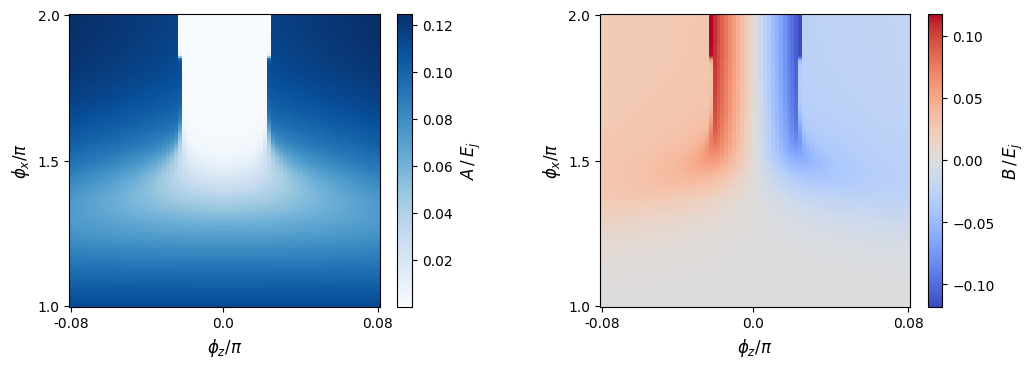

In [261]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
fig.tight_layout(pad=10)

pcm0 = axs[0].imshow(As, aspect="auto", origin="lower", cmap="Blues", interpolation='none')
axs[0].set_xlabel(r"$\phi_z / \pi$", fontsize=12)
axs[0].set_ylabel(r"$\phi_x / \pi$", fontsize=12)
axs[0].set_xticks([0, 39, 79], [-0.08, 0.0, 0.08])
axs[0].set_yticks([0, 69, 139], [1.0, 1.5, 2.0])
cb = fig.colorbar(pcm0, fraction=0.06)
cb.set_label(r"$A \, / \, E_j$", size=12, labelpad=5)

pcm1 = axs[1].imshow(Bs, aspect="auto", origin="lower", cmap="coolwarm", interpolation='none')
axs[1].set_xlabel(r"$\phi_z / \pi$", fontsize=12)
axs[1].set_ylabel(r"$\phi_x / \pi$", fontsize=12)
axs[1].set_xticks([0, 39, 79], [-0.08, 0.0, 0.08])
axs[1].set_yticks([0, 69, 139], [1.0, 1.5, 2.0])
cb = fig.colorbar(pcm1, fraction=0.06)
cb.set_label(r"$B \, / \, E_j$", size=12, labelpad=5)

plt.show()

## Part 2 - Quantum annealing

A very common quantum gate is the <a href="https://en.wikipedia.org/wiki/Quantum_logic_gate">Hadamard gate</a>. This gate can be used to move a qubit in an eigenstate of the $\sigma_z$ basis (the basis in which we typically measure the qubit for gate based computing) to an equal superposition of the basis' eigenstates. Feel free to do the calculation by yourself by seeing how the gate matrix acts on either the $|0\rangle$ or the $|1\rangle$ states.

#### Exercise 1
What could be the initial and final hamiltonians of an annealing algorithm to perform a Hadamard gate on an analog quantum computer?

Since the states obtained when a Hadamard gate is applied over the computational basis are the eigenstates of $\sigma_x$, we can propose the following Hamiltonian
$$
\hat{H}=s\sigma_x + (1-s)\sigma_z
$$
where $s=\frac{t}{T}\in[0,1]$ is a normalized temporal parameter and $T$ the maximus time.

#### Exercise 2
Design an annealing schedule for the hamiltonians above. Find appropiate values of $\Delta$ and $\varepsilon$ within the annealing region from your findings in Part 1. Do not worry too much about adiabaticity here, this will be tackled in the next section.

We choose, as a path, $(\Phi_z/\pi,\Phi_x/\pi)=(0.015,2-s)$, so $B(0)\neq 0$, $B(s=1)= 0$, $A(0)= 0$ and $A(s=1)\neq 0$, as seen in the figure below.

In [313]:
phi_z = - 0.015 * np.pi
ss = np.linspace(0, 1, 100)

Hs_energy_g = []
Hs_energy_e = []
for s in ss:
    phi_x = (2-s) * np.pi
    H = qubit.get_h(phi_x, phi_z)
    dict_energy_state = sort_trash_from_eigsh(*eigsh(H, k=2, which="SA", return_eigenvectors=True))
    energies = list(dict_energy_state.keys())
    Hs_energy_g.append(energies[0])
    Hs_energy_e.append(energies[1])   
    ##########################################################################
    H_p = qubit.get_h(phi_x, phi_z + dphi_z)
    H_m = qubit.get_h(phi_x, phi_z - dphi_z)
    dH = 0.5 * (H_p - H_m) / dphi_z
    Ip_g = dH @ dict_energy_state[energies[0]]
    Ip_e = dH @ dict_energy_state[energies[1]]
    Ip = np.array([
         [np.vdot(dict_energy_state[energies[0]], Ip_g), np.vdot(dict_energy_state[energies[0]], Ip_e)],
         [np.vdot(dict_energy_state[energies[1]], Ip_g), np.vdot(dict_energy_state[energies[1]], Ip_e)]
         ]) 
    ##########################################################################
    dict_current_state = sort_trash_from_eigsh(*eigsh(Ip, k=2, which="SA", return_eigenvectors=True))
    currents = list(dict_current_state.keys())
    Is_bases[str(s)] = np.column_stack((dict_current_state[currents[0]], dict_current_state[currents[1]]))
    clear_output(wait=True)
    print(str(round(s, 2)) + "/1")

1.0/1


In [314]:
As = []
Bs = []
Cs = []
Hs_eff_energy_g = []
Hs_eff_energy_e = []
for i, s in enumerate(ss):
    phi_x = 2 - s
    H_diag = diags([Hs_energy_g[i], Hs_energy_e[i]])
    U = Is_bases[str(s)]
    H_eff = U.conj().T @ H_diag @ U
    dict_energy_state = sort_trash_from_eigsh(*eigsh(H_eff, k=2, which="SA", return_eigenvectors=True))
    energies = list(dict_energy_state.keys())
    Hs_eff_energy_g.append(energies[0])
    Hs_eff_energy_e.append(energies[1])  
    ax = np.real((SIG_X @ H_eff).trace())
    ay = np.real((SIG_Y @ H_eff).trace())
    angle = - np.atan2(ay, ax)
    R = diags([np.exp(- angle * 1j / 2), np.exp(angle * 1j / 2)])
    H_eff_rot = R @ H_eff @ R.conj().T
    As.append(np.real((SIG_X @ H_eff_rot).trace()) / (200 * np.pi))
    Bs.append(np.real((SIG_Z @ H_eff_rot).trace()) / (200 * np.pi))
    Cs.append(np.real((SIG_Y @ H_eff_rot).trace()) / (200 * np.pi))

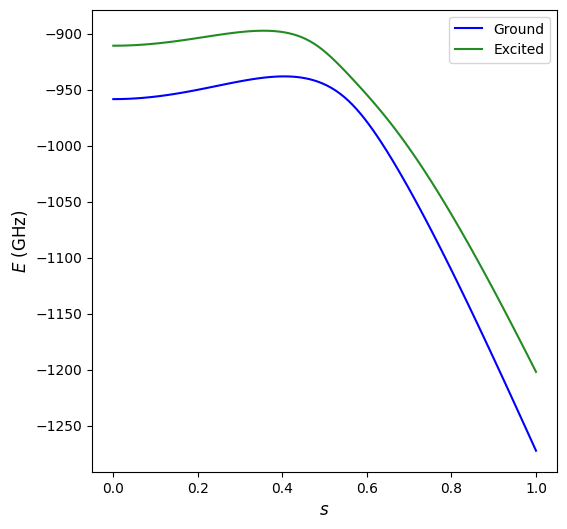

In [315]:
plt.figure(figsize=(6, 6))

plt.plot(ss, Hs_eff_energy_g, label="Ground", color="blue")
plt.plot(ss, Hs_eff_energy_e, label="Excited", color="forestgreen")
plt.xlabel(r"$s$", fontsize=12)
plt.ylabel(r"$E$ (GHz)", fontsize=12)
plt.legend()

plt.show()

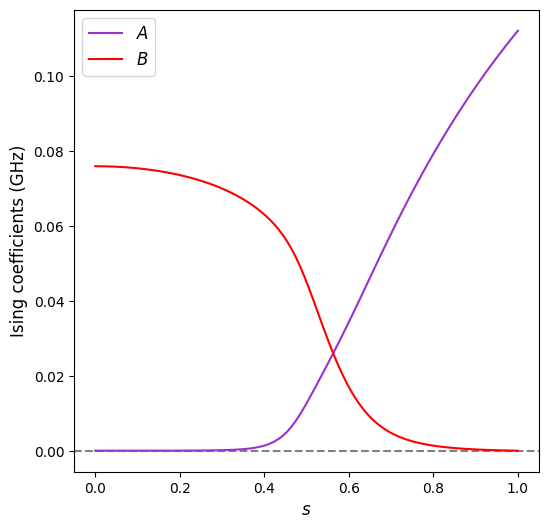

In [316]:
plt.figure(figsize=(6, 6))

plt.axhline(0, color="gray", ls="--")
plt.plot(ss, As, label=r"$A$", color="darkorchid")
plt.plot(ss, Bs, label=r"$B$", color="red")
plt.xlabel(r"$s$", fontsize=12)
plt.ylabel(r"Ising coefficients (GHz)", fontsize=12)
plt.legend(fontsize=12)

plt.show()

#### Exercise 3

Find a schedule for the analog Hadamard gate which fulfills adiabaticity

In the previous figure we have seen that the energies of the ground state and the first excited do not become equal, so the adiabatic theorem is fulfilled. We can also check the lower limit of $T$

In [320]:
gaps = [E_1 - E_0 for E_1, E_0 in zip(Hs_eff_energy_e, Hs_eff_energy_g)]
g = min(gaps)

In [ ]:
epss = []
for i in range(1, 99):
    H_eff = As[i] * SIG_X + Bs[i] * SIG_Z
    H_eff_p = As[i + 1] * SIG_X + Bs[i + 1] * SIG_Z
    H_eff_m = As[i - 1] * SIG_X + Bs[i - 1] * SIG_Z
    dH_eff = (H_eff_p - H_eff_m) / 0.02
    dict_energy_state = sort_trash_from_eigsh(*eigsh(H_eff, k=2, which="SA", return_eigenvectors=True))
    energies = list(dict_energy_state.keys())
    epss.append(abs(np.vdot(dict_energy_state[energies[1]], dH_eff @ dict_energy_state[energies[0]])))
eps = max(epss)

In [332]:
T = eps / g**2
print("T >> " + str(round(T, 6)) + " ns")

T >> 0.000674 ns


## Part 3 - Open challenge

#### Exercise 1
Given the analog algorithm for the Hadamard gate, optimize it so that the schedule total time is minimal while still fulfilling adiabaticity.

The optimized path should be that which maximized the minimun energy gap and minimized the value of $\varepsilon$.

#### Exercise 2
Explore the same problem for a 2 qubit gate of your choice. You can find examples on how to create coupled systems on the <a href="https://github.com/USCqserver/CAS/blob/master/docs/examples/multi_qubit_schedules.ipynb">CAS repository</a>

